Load SpatioTemporal Asset Catalogs (STAC) collections in WherobotsDB
Connecting to a STAC API: Learn how to establish a connection to a STAC API endpoint.
Searching items and load them into WherobotsDB: See how to load STAC collections into WherobotsDB for further analysis.
Applying Spatial and Temporal Filters: Learn to filter the data based on spatial and temporal criteria to focus on specific areas and time periods.
Saving Data: Discover how to save the filtered data into various formats for further use.

The STAC data source enables seamless integration with SpatioTemporal Asset Catalog (STAC) APIs, allowing users to efficiently read and interact with geospatial data. This data source supports reading both STAC items and collections, making it a versatile tool for various geospatial data processing tasks. To utilize the STAC data source, you can load a STAC catalog into a Sedona DataFrame using the stac format. The path can be either a local STAC collection JSON file or an HTTP/HTTPS endpoint to retrieve the collection JSON file. This flexibility allows for easy access to both locally stored and remotely hosted STAC data.

Technical Details:
STAC API Integration: Connect to any STAC-compliant API to fetch and process geospatial data.
DataFrame Support: Load STAC data directly into a Sedona DataFrame for further analysis and processing using Spark.
Flexible Input Paths: Accepts both local file paths and remote URLs, providing versatility in data sourcing.
Potential Use Cases:
Geospatial Data Analysis: Perform complex spatial queries and analyses on large geospatial datasets.
Environmental Monitoring: Access and analyze satellite imagery and other remote sensing data for environmental studies.
Urban Planning: Utilize geospatial data to support urban development and infrastructure planning.
Disaster Response: Quickly access and process geospatial data to aid in disaster response and recovery efforts.

STAC datasources are hosted on AWS S3, and to configure Apache Sedona for anonymous access to an Amazon S3 bucket, you can set the spark.hadoop.fs.s3a.bucket..aws.credentials.provider property to org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider. This setting directs Sedona to use the AnonymousAWSCredentialsProvider, enabling access to publicly accessible S3 buckets without requiring AWS credentials.

In [1]:
from sedona.spark import *

config = SedonaContext.builder() \
    .config("spark.hadoop.fs.s3a.bucket.e84-earth-search-sentinel-data.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")\
    .getOrCreate()
sedona = SedonaContext.create(config)



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Usege Apache Sedona and PySpark to load STAC data from the Sentinel-2 collection via a specified URL. It then explodes the “assets” map into key-value pairs, extracting the “href” and “rast” fields from the “value” struct. 

In [2]:
from pyspark.sql.functions import col, explode, map_values

In [3]:
# Load from STAC datasource
df = sedona.read.format("stac") \
    .load("https://earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a") \
    .orderBy(col("datetime").desc())
df.printSchema() 

root
 |-- stac_version: string (nullable = false)
 |-- stac_extensions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- type: string (nullable = false)
 |-- id: string (nullable = false)
 |-- bbox: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- geometry: geometry (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- start_datetime: timestamp (nullable = true)
 |-- end_datetime: timestamp (nullable = true)
 |-- created: timestamp (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- instruments: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- constellation: string (nullable = true)
 |-- mission: string (nullable = true)
 |-- gsd: double (nullable = true)
 |-- collection: string (nullable = true)
 |-- links: array (nullable = true)
 |    |-- element: struct (co

In [4]:
# Explode the map into key-value pairs
df_exploded = df.select("id", "datetime", explode("assets").alias("key", "value"))

In [5]:
df_exploded.show(3)

+--------------------+--------------------+--------+--------------------+
|                  id|            datetime|     key|               value|
+--------------------+--------------------+--------+--------------------+
|S2A_T32VPN_202503...|2025-03-24 10:44:...|  swir16|{https://e84-eart...|
|S2A_T32VPN_202503...|2025-03-24 10:44:...|  swir22|{https://e84-eart...|
|S2A_T32VPN_202503...|2025-03-24 10:44:...|rededge1|{https://e84-eart...|
+--------------------+--------------------+--------+--------------------+
only showing top 3 rows



In [7]:
type(df_exploded)

pyspark.sql.dataframe.DataFrame

In [8]:
df_exploded.count()

230

In [9]:
df_exploded.show(truncate = False)

+------------------------------+-----------------------+-----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                            |datetime               |key              |value                                                                                                                                                                                                                                                                                   |
+------------------------------+-----------------------+-----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Select the 'rast' field from the 'value' struct
df_rast = df_exploded.select(
    col("id"), 
    col("datetime"), 
    col("key"), 
    col("value.href").alias("href"), 
    col("value.rast").alias("rast"),
    col("value.title").alias("title"),
    col("value.roles").alias("elem")
)

In [11]:
df_rast.show(3)

+--------------------+--------------------+--------+--------------------+--------------------+----------------+-------------------+
|                  id|            datetime|     key|                href|                rast|           title|               elem|
+--------------------+--------------------+--------+--------------------+--------------------+----------------+-------------------+
|S2A_T32VPN_202503...|2025-03-24 10:44:...|  swir16|https://e84-earth...|LazyLoadOutDbGrid...|SWIR 1.6μm - 20m|[data, reflectance]|
|S2A_T32VPN_202503...|2025-03-24 10:44:...|  swir22|https://e84-earth...|LazyLoadOutDbGrid...|SWIR 2.2μm - 20m|[data, reflectance]|
|S2A_T32VPN_202503...|2025-03-24 10:44:...|rededge1|https://e84-earth...|LazyLoadOutDbGrid...|Red Edge 1 - 20m|[data, reflectance]|
+--------------------+--------------------+--------+--------------------+--------------------+----------------+-------------------+
only showing top 3 rows



In [14]:
df_rast.count()

230

Integrate with OutDB Raster
filter the df_rast DataFrame to select rows where the href column ends with .tif, limits the results to 4 rows, and converts the rast field into an image using the RS_AsImage function. The resulting DataFrame, which contains the generated images, is then displayed using SedonaUtils.display_image.

,raster_image1
0,
1,
2,
3,

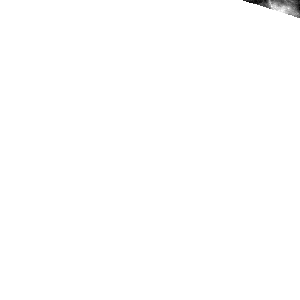
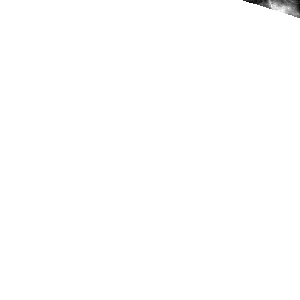
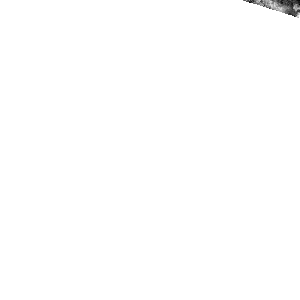
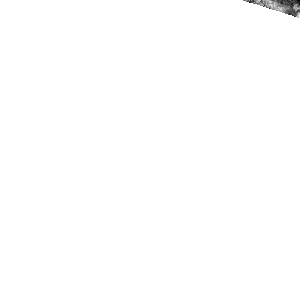

In [15]:
from pyspark.sql import functions as F

# Filter the DataFrame for '.tif' hrefs and limit to 4 items
dfImage = df_rast.filter(F.col("href").endswith(".tif")) \
    .limit(4) \
    .selectExpr("RS_AsImage(rast, 300) as raster_image1")

# Display the image
SedonaUtils.display_image(dfImage)


Python STAC API
The STAC data source can also be loaded and searched using a new Python API. 

Initialize a STAC client by importing the Client class from the sedona.stac.client module and the DataFrame class from pyspark.sql. It then opens the client to connect to the Earth Search API using the specified URL (https://earth-search.aws.element84.com/v1).

In [16]:
from sedona.stac.client import Client
from pyspark.sql import DataFrame

# Initialize the client
client = Client.open("https://earth-search.aws.element84.com/v1")


uses the client.search() method to query the “sentinel-2-c1-l2a” collection from the STAC API, filtering results for items from the year 2025. It sets the return_dataframe parameter to False, meaning the search results will not be returned as a DataFrame. Finally, it prints the retrieved items.

In [17]:
# Search items on a collection within a year
items = client.search(
    collection_id="sentinel-2-c1-l2a",
    datetime="2025",
    return_dataframe=False
)

# Print the count of items
items_list = list(items)
print(f"Loaded items: {len(items_list)}")


Loaded items: 10


In [16]:
print(items_list)

[<Item id=S2A_T33VUH_20250324T103713_L2A>, <Item id=S2A_T33VVH_20250324T103713_L2A>, <Item id=S2A_T33VWJ_20250324T103713_L2A>, <Item id=S2A_T34WDS_20250324T103713_L2A>, <Item id=S2A_T33WVP_20250324T103713_L2A>, <Item id=S2A_T34WDT_20250324T103713_L2A>, <Item id=S2A_T33WVR_20250324T103713_L2A>, <Item id=S2A_T34WEU_20250324T103713_L2A>, <Item id=S2A_T34WEV_20250324T103713_L2A>, <Item id=S2A_T35XNE_20250324T103713_L2A>]


In [17]:
# Search items with bounding box and interval
items = client.search(
    collection_id="sentinel-2-c1-l2a",
    bbox=[-180.0, -90.0, 180.0, 90.0],
    datetime="2025",
    return_dataframe=False
)

# Print the count of items
items_list = list(items)
print(f"Loaded items: {len(items_list)}")


Loaded items: 10


In [18]:
print(items_list)

[<Item id=S2A_T32VPN_20250324T103713_L2A>, <Item id=S2A_T33VUH_20250324T103713_L2A>, <Item id=S2A_T33VVH_20250324T103713_L2A>, <Item id=S2A_T32VNP_20250324T103713_L2A>, <Item id=S2A_T33VWH_20250324T103713_L2A>, <Item id=S2A_T33VVJ_20250324T103713_L2A>, <Item id=S2A_T32VNQ_20250324T103713_L2A>, <Item id=S2A_T33VWJ_20250324T103713_L2A>, <Item id=S2A_T33VVK_20250324T103713_L2A>, <Item id=S2A_T32VNR_20250324T103713_L2A>]


In [19]:
# Search items with bounding box and interval
items = client.search(
    collection_id="sentinel-2-c1-l2a",
    bbox=[-180.0, -90.0, 180.0, 90.0],
    datetime="2025",
    return_dataframe=False
)

# Print the count of items
items_list = list(items)
print(f"Loaded items: {len(items_list)}")


Loaded items: 10


Save to STAC GeoParquet format.
Use a stac df to stac geoparquet converter that can be used to write geoparquet without requiring users to explicitly cast the schema or explode the dataframe. This could potentially be implemented in stac_geopaquet writer using a stac df loaded if feasible.

Connect to the Microsoft Planetary Computer’s STAC API to fetch the “aster-l1t” collection. It defines spatial (bounding box) and temporal (datetime interval) extents for the data to be saved. The script checks if a specified output path (/tmp/stac_temp_aster-l1t) exists, deletes it if it does, and then saves the filtered items to GeoParquet. Afterward, it reads the saved GeoParquet data into a Spark DataFrame and displays the contents. Finally, it cleans up by deleting the output path again.

In [19]:
client_stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
collection = client_stac.get_collection("aster-l1t")

# Definicja zakresów przestrzennych i czasowych
bbox = [[-180.0, -90.0, 180.0, 90.0]]
datetime = [["2006-01-01T00:00:00Z", "2007-01-01T00:00:00Z"]]

import os
import shutil

output_path = "/tmp/stac_temp_aster-l1t"

# Usuń folder output_path, jeśli istnieje
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Zapisz dane do GeoParquet
collection.save_to_geoparquet(
    output_path=output_path, bbox=bbox, datetime=datetime
)

# Usuń folder output_path, jeśli istnieje (opcjonalne)
if os.path.exists(output_path):
    shutil.rmtree(output_path)

In [23]:
client_stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
collection = client_stac.get_collection("aster-l1t")

# Definicja zakresów przestrzennych i czasowych
bbox = [[-180.0, -90.0, 180.0, 90.0]]
datetime = [["2006-01-01T00:00:00Z", "2007-01-01T00:00:00Z"]]

import os
import shutil

output_path = "/tmp/stac_temp_aster-l1t"

# Usuń folder output_path, jeśli istnieje
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Zapisz dane do GeoParquet
collection.save_to_geoparquet(
    output_path=output_path, bbox=bbox, datetime=datetime
)
